# Controller behavior

I want to see how the controller is behaving, particularly
1. Is the error staying below the target?
2. How are the controller parameters, uncertainty, and error varying with time
3. How well is the UQ correlated with the error

Right now I am looking at one of our NVT trajectories. 

The answers are 
1. Yes, but there are some very large outliers **I think the outliers could be from the max over forces...**
2. The threshold varies a lot faster than the UQ, which worries me. I think this is driven by the large errors making the update large
3. The correlation is extremely weak

I think we need to look a little bit into
1. how we are getting the alpha -- this `np.true_divide` approach is a little unrigorous for me
2. if we can't improve the correlation between UQ and error somewhat, at least with a larger ensemble, if not with something a little bit smarter.
3. whether it really makes sense to use the max force. I get that for something like a vacancy hop the error on only one atom matters. But im afraid the error signal is so peaky that it results in very large updates, so the threshold is swinging around rapidly.
4. PID control -- this could solve the issue in #3, but then we have to worry about the coefficients. 

In [1]:
from pathlib import Path
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import scipy as sp
from scipy import stats

In [2]:
run_dir = Path('./runs/800K-npt-single-train/si-vacancy-2x2x2-temp=800.0-method=lda-blend=0-160f5dc6/')

In [3]:
#run_dur = Path('./runs/800K-npt-single-train/si-vacancy-2x2x2-temp\=800.0-method\=lda-blend\=10-0474190d')

In [4]:
#run_dir = Path('./runs/nvt-fixed-temp/si-vacancy-2x2x2-temp=1573.0-method=lda-blend=0-2bcd06d4/')

In [5]:
data = pd.read_json(run_dir/'proxima-log.json', lines=True)

In [6]:
with open(run_dir/'params.json') as f: 
    params = json.load(f)
params

{'file': None,
 'starting_strc': '/home/mtynes/cascade/0_setup/initial-geometries/si-vacancy-2x2x2.vasp',
 'temperature': 800.0,
 'timestep': 1,
 'calculator': 'lda',
 'ensemble': 'npt',
 'temp_tau': 25,
 'stress_tau': 25.0,
 'steps': 2048,
 'seed': 0,
 'bulk_modulus': 98.0,
 'model_type': 'ani',
 'initial_model': None,
 'initial_data': [],
 'ensemble_size': 2,
 'online_training': True,
 'training_epochs': 32,
 'training_batch_size': 32,
 'training_max_size': None,
 'training_recency_bias': 1.0,
 'training_device': 'cpu',
 'target_error': 0.9,
 'error_history': 8,
 'retrain_freq': 1024,
 'min_target_frac': 0.2,
 'n_blending_steps': 0,
 'cascade_commit': '884fa037daca2f12f3c528117ba8a386033dfd71',
 'my_commit': '884fa037daca2f12f3c528117ba8a386033dfd71',
 'start_time': '2024-08-20T10:47:59.995349'}

# How often are we using the surrogate?

In [7]:
t = np.arange(data.shape[0]) # need for scatter plots

In [8]:
data['used_surrogate'].mean()

0.22265625

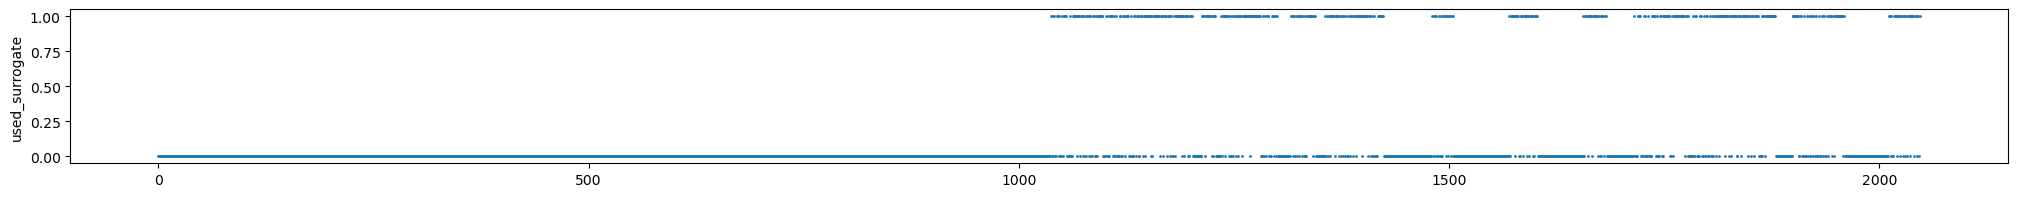

In [9]:
fig, ax = plt.subplots(figsize=(25, 2))
plt.scatter(t, data['used_surrogate'], s=1)
plt.ylabel('used_surrogate')
plt.show()

It looks like we are switching it on and off pretty rapidly for most of the simulation. 

# Error vs target

I just want to see if we are staying below the target

In [10]:
target_error = params['target_error']

### Filter out the steps where we used the target
I don't want to overcount errors when the surrogate is used for multiple steps in a row

In [11]:
target_idx = data['used_surrogate'] == False

In [12]:
target_steps = data.query('used_surrogate == False')

In [13]:
t_target = t[target_idx]

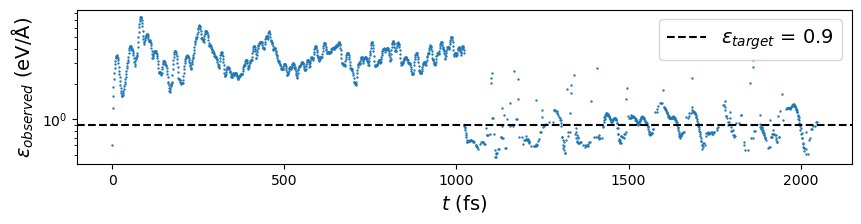

In [14]:
start_ix = 0
fig, ax = plt.subplots(figsize=(10, 2))
plt.scatter(t_target[start_ix:], target_steps['last_error'][start_ix:], s=0.5)
plt.axhline(0.9, color='k', linestyle='dashed', label='$\epsilon_{target}$ = 0.9')
plt.yscale('log')
plt.ylabel('$\epsilon_{observed}$ (eV/$\mathrm{\AA}$)', fontsize=14)
plt.xlabel('$t$ (fs)', fontsize=14)
plt.legend(fontsize=14)
plt.savefig('controller.png', bbox_inches='tight', dpi=500)
plt.show()

It looks like we are staying below the threshold most of the time, but there are some pretty large outliers.  
On average we are a little above the error, but once you remove the burnin period we are below the average

In [15]:
start_ix = 1024
filtered = target_steps['last_error'][start_ix:]
filtered.mean()

0.9224285762676634

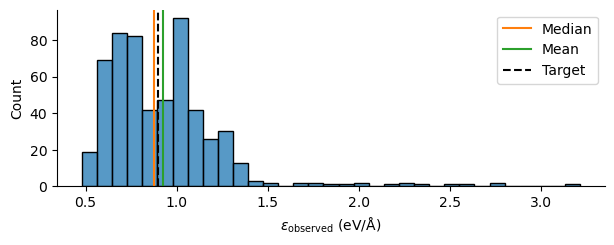

0.9224285762676634 0.8730146230428976


In [16]:
#sns.set_theme(rc={'figure.figsize':(5,2)}, style="whitegrid",)
mean, median = filtered.mean(), filtered.median()
g = sns.displot(filtered, 
                #log_scale=True,
                height=2.5, 
                aspect=5/2,
               )
g.ax.axvline(median, 
             color='tab:orange', 
             label='Median')
g.ax.axvline(mean,
             color='tab:green', 
             label='Mean')
g.ax.axvline(target_error, color='k', linestyle ='dashed', label='Target')
plt.xlabel('$\epsilon_\mathrm{observed}$ (eV/$\mathrm{\AA}$)')
plt.legend()
plt.savefig('observed_error_histogram.png', dpi=500, bbox_inches='tight')
plt.show()
print(mean, median)

# to really know if we got it right, you need to run DFT on the frames that are in the trajectory


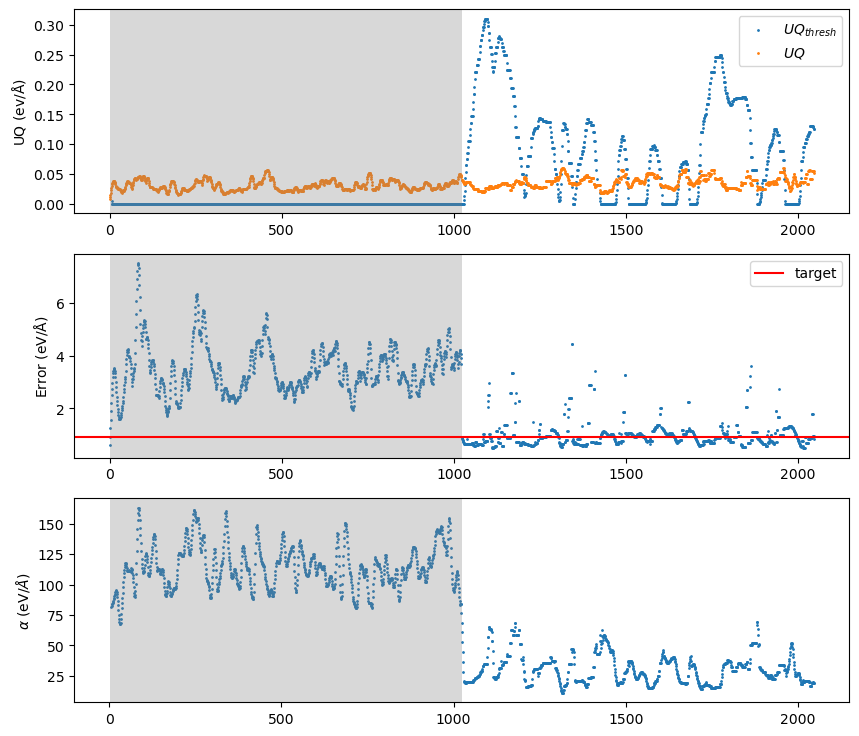

In [17]:
fig, ax = plt.subplots(3, figsize=(10, 9))
plt.sca(ax[0])
plt.scatter(t, data['proxima_threshold'], s=1, label='$UQ_{thresh}$')
plt.scatter(t, data['last_uncer'], s=1, label='$UQ$')
plt.ylabel('UQ (ev/$\mathrm{\AA}$)')
#plt.axvline(1024, color='k')
plt.legend()
ax[0].axvspan(1, 1024, facecolor='grey', alpha=0.3)

plt.sca(ax[1])
plt.scatter(t, data['last_error'], s=1)
plt.ylabel('Error (eV/$\mathrm{\AA}$)')
plt.axhline(target_error, color='red', label='target')
#plt.axvline(1024, color='k', alpha=0.5)
ax[1].axvspan(1, 1024, facecolor='grey', alpha=0.3)
plt.legend()

plt.sca(ax[2])
plt.scatter(t, data['proxima_alpha'], s=1, label=r'$\alpha$')
plt.ylabel(r'$\alpha$ (eV/$\AA$)')
ax[2].axvspan(1, 1024, facecolor='grey', alpha=0.3)

#plt.axvline(1024, color='k')

#plt.legend()
#plt.yscale('log')
#plt.grid(True, which='both')
plt.show()

I don't like that tere is a lot more variability in the threshold than in the UQ.  
I think thats probably related to the very large outlier errors. And perhaps our lack of integral control?   
But it seems like the UQ isnt influencing our decisions that much, sicne the threshold is moving around much more.

In [18]:
plt.cm.Pastel1([0, 1, 2, 3])

array([[0.98431373, 0.70588235, 0.68235294, 1.        ],
       [0.70196078, 0.80392157, 0.89019608, 1.        ],
       [0.8       , 0.92156863, 0.77254902, 1.        ],
       [0.87058824, 0.79607843, 0.89411765, 1.        ]])

In [19]:
start, stop = 1024, 1400

In [20]:
_data = data.iloc[start:stop]

In [21]:
t = np.arange(start, stop)

In [22]:
obs_error_ix = np.where(np.diff(_data['last_error']) != 0)[0]

In [23]:
filtered = data.iloc[1024:]
below_thresh = filtered.loc[filtered['last_uncer'] < filtered['proxima_threshold']]
(~below_thresh['used_surrogate']).mean()

0.37777777777777777

In [24]:
data.shape

(2048, 16)

## todo: 
- [ ] make this a function   
- [ ] plot the whole trajectory   
- [ ] look at the nvt runs with more model versions  

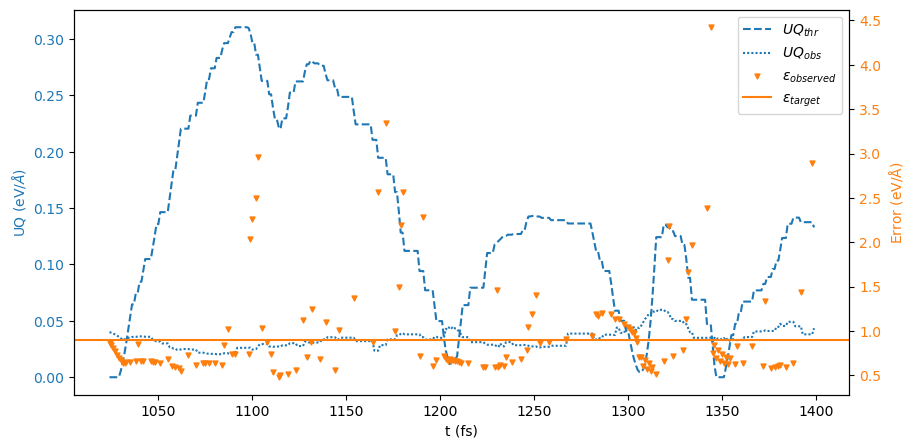

In [25]:
# plot UQ and error on the same plot using a twin axis
# (These quantities have different scales)

fig, ax = plt.subplots(figsize=(10, 5))
axs = [ax, ax.twinx()]

# we'll want to re-use the colors for different objects
color_UQ, color_err = plt.cm.tab10([0, 1])

# plot UQ on the left axis
plt.sca(axs[0])
p1 = plt.plot(t,
              _data['proxima_threshold'],
              label='$UQ_{thr}$',
              linestyle='dashed',
              color=color_UQ)
p2 = plt.plot(t, 
              _data['last_uncer'], 
              label='$UQ_{obs}$',
              linestyle=(0, (1,1)),
              color=color_UQ
             )


axs[0].tick_params(axis='y', labelcolor=color_UQ)
axs[0].set_ylabel('UQ (eV/$\AA$)', color=color_UQ)

# plot error on the righthand axis
plt.sca(axs[1])
p3 = plt.scatter(t[obs_error_ix],
                 _data['last_error'].iloc[obs_error_ix], 
                 color=color_err,
                 s=12.5,
                 marker='v',
                 label='$\epsilon_{observed}$'
                )
plt.axhline(target_error, 
            color=color_err,
            label='$\epsilon_{target}$')
axs[1].tick_params(axis='y', labelcolor=color_err)
axs[1].set_ylabel('Error (eV/$\mathrm{\AA}$)', color=color_err)


# make a combined legend
h1, l1 = axs[0].get_legend_handles_labels()
h2, l2 = axs[1].get_legend_handles_labels()
handles = h1+h2
labels = l1+l2
plt.legend(handles, labels)

# everything shares an x label
axs[0].set_xlabel('t (fs)')
plt.show()

In [26]:
def plot_transitions(ax, data, t):

    # include offset if we dont start at zero
    start = t[0]
    transition_points = np.where(np.diff(data['model_version']))[0] + t[0] 
    
    for axis in ax:
        # Highlight logic
        if len(transition_points) == 1:
            # Highlight from 0 to the single transition point
            axis.axvspan(start, transition_points[0], color='grey', alpha=0.3)
        elif len(transition_points) > 1:
            # Highlight between every other pair
            for i in range(0, len(transition_points) - 1, 2):
                start = transition_points[i]
                end = transition_points[i + 1]
                axis.axvspan(start, end, color='grey', alpha=0.3)

In [27]:
def plot_uq_error(data, params, s=12.5, ax=None):

    uq_obs=data['last_uncer'].array
    uq_thr=data['proxima_threshold'].array
    error_obs=data['last_error'].array
    error_target = params['target_error']
    t = np.asarray(data.index)

    uq_obs, uq_thr, error_obs, error_target

    if ax is None:
        _, ax = plt.subplots(figsize=(10, 5))
    axs = [ax, ax.twinx()]
    
    # we'll want to re-use the colors for different objects
    color_UQ, color_err = plt.cm.tab10([0, 1])

    error_ix = np.where(np.diff(error_obs) != 0)[0]
    
    # plot UQ on the left axis
    plt.sca(axs[0])
    p2 = plt.plot(t, 
                  uq_obs, 
                  label='$UQ_{obs}$',
                  linestyle='dashed',
                  color=color_UQ
                 )
    p1 = plt.plot(t,
                  uq_thr,
                  label='$UQ_{thr}$',
                  linestyle=(0, (1,1)),
                  color=color_UQ)
    
    
    axs[0].tick_params(axis='y', labelcolor=color_UQ)
    axs[0].set_ylabel('UQ (eV/$\AA$)', color=color_UQ)
    
    # plot error on the righthand axis
    plt.sca(axs[1])
    p3 = plt.scatter(t[error_ix],
                     error_obs[error_ix], 
                     color=color_err,
                     s=s,
                     marker='v',
                     label='$\epsilon_{obs}$'
                    )
    plt.axhline(error_target, 
                color=color_err,
                label='$\epsilon_{target}$')
    axs[1].tick_params(axis='y', labelcolor=color_err)
    axs[1].set_ylabel('Error (eV/$\mathrm{\AA}$)', color=color_err)
    
    
    # make a combined legend
    h1, l1 = axs[0].get_legend_handles_labels()
    h2, l2 = axs[1].get_legend_handles_labels()
    handles = h1+h2
    labels = l1+l2
    plt.legend(handles, labels)

    plot_transitions(axs, data, t)
    
    # everything shares an x label
    axs[0].set_xlabel('t (fs)')
    return ax

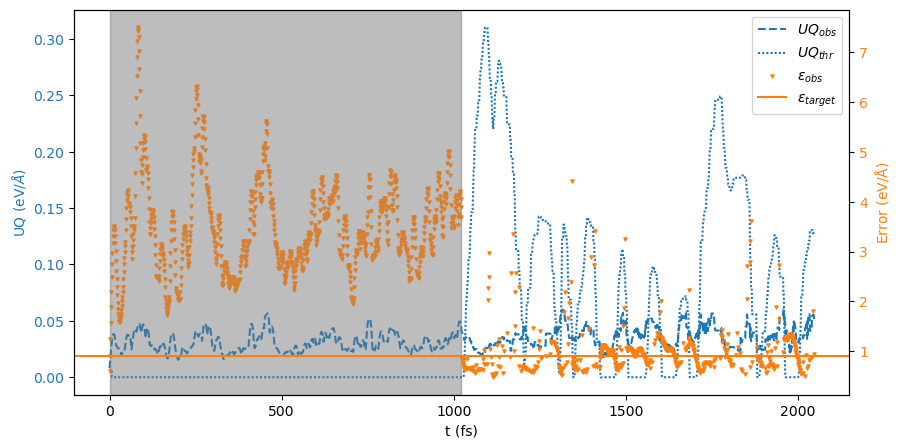

In [28]:
plot_uq_error(data, params, s=5)
plt.show()

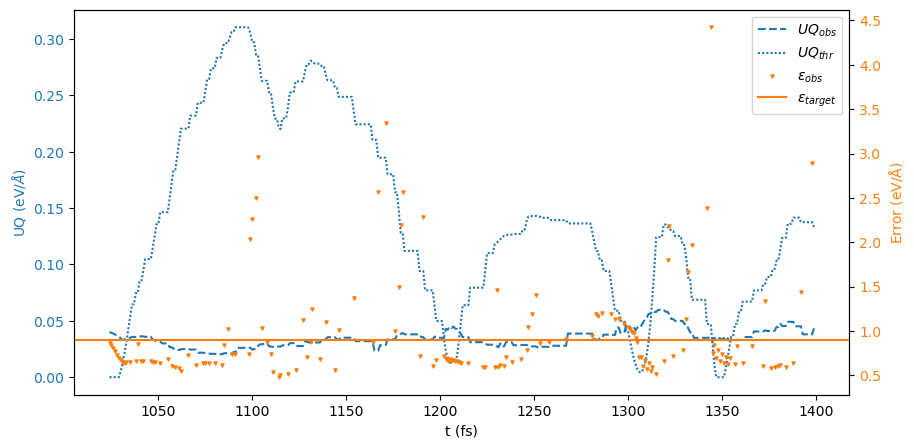

In [29]:
start, stop = 1024, 1400
_data = data.iloc[start:stop]
plot_uq_error(_data, params, s=5)
plt.show()

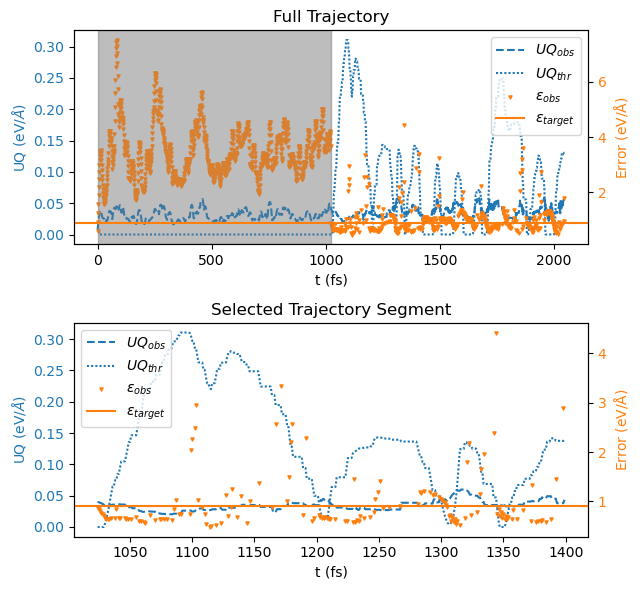

In [30]:
fig, axes = plt.subplots(2, figsize=(6.5, 6))
D = [data, _data]
titles = ['Full Trajectory', 'Selected Trajectory Segment']
for i, d in enumerate(D):
    ax = axes[i]
    plot_uq_error(d, params, s=5, ax=ax)
    plt.title(titles[i])
plt.tight_layout()
plt.savefig('controller_behavior_npt.png', dpi=500, bbox_inches='tight')
plt.show()

In [31]:
%pdb

Automatic pdb calling has been turned ON


plot

## UQ vs error

This looks a little rough in aggregate, but I (and Logan) think we should be looking by model version, to be sure. 

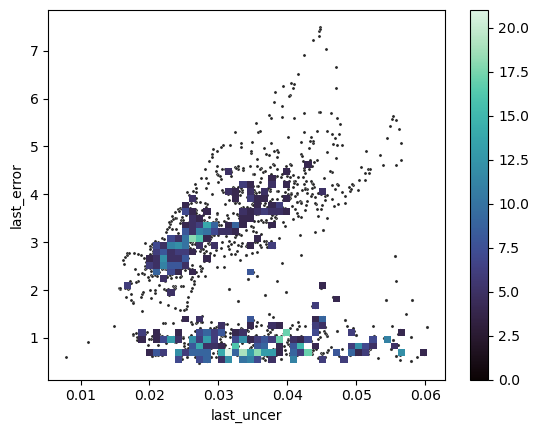

In [32]:
sns.scatterplot(x=data['last_uncer'], y=data['last_error'], s=5, color=".15")
sns.histplot(x=data['last_uncer'], y=data['last_error'], bins=50, pthresh=0.22, cmap="mako", cbar=True)
plt.show()

In [33]:
sp.stats.spearmanr(data['last_uncer'], data['last_error'])

SignificanceResult(statistic=-0.022374540738312645, pvalue=0.3115071542044292)

Its actually pretty crazy how well this works considering how poorly correlated the UQ is with error. 

## By model version (looking only at the steps where we have a target eval)

In [34]:
def annotate(data, **kws):
    r, p = sp.stats.spearmanr(data['last_error'], data['last_uncer'])
    ax = plt.gca()
    ax.text(.05, .8, 'spearmanr={:.2f}'.format(r),
            transform=ax.transAxes, 
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

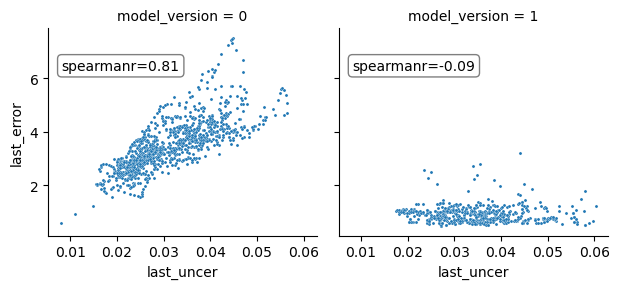

In [35]:
g = sns.FacetGrid(data=target_steps, col='model_version', col_wrap=5)
g.map(sns.scatterplot, 'last_uncer', 'last_error', s=5)
g.map_dataframe(annotate)
plt.show()

## Sanity checking the alpha fitting

The way it is in the present implementation:

In [36]:
many_alphas = np.true_divide(target_steps['last_error'], np.clip(target_steps['last_uncer'], 1e-6, a_max=np.inf))  # Alpha's units: error / UQ
alpha = np.mean(many_alphas)
alpha

83.5236255267967

In [37]:
from sklearn.linear_model import LinearRegression

The way its done here https://github.com/globus-labs/sluschi-proxima/blob/57b6ee0e960facc228066bd863ebf10c330b51b0/mddemo/decorator.py#L168 

In [38]:
lr = LinearRegression(fit_intercept=False)

In [39]:
lr.fit(X=target_steps['last_error'].array[:, np.newaxis], y=target_steps['last_uncer'])
lr.coef_

array([0.00974089])

In [40]:
lr.fit(X=target_steps['last_uncer'].array[:, np.newaxis], y=target_steps['last_error'])
lr.coef_

array([74.90839574])

## look at an nvt diffusion trajectory

In [41]:
ls runs

 800K-npt-single-train/
 batchio/
 berendsen/
 cost-accuracy/
 illustration-long/
 npt-diffusion-temp-sweep/
 npt-rerun/
 npt-vol-equil-temp-sweep/
 nvt-fixed-temp/
 nvt-fixed-temp-high-lambda/
'si-vacancy-2x2x2-temp=1573.0-method=lda-blend=10-4065eb7d'/


In [42]:
run_dir = Path('./runs/nvt-fixed-temp/si-vacancy-2x2x2-temp=1573.0-method=lda-blend=0-10ce8f31/')

In [43]:
data = pd.read_json(run_dir/'proxima-log.json', lines=True)

In [44]:
with open(run_dir/'params.json') as f: 
    params = json.load(f)
params

{'file': None,
 'starting_strc': '../0_setup/initial-geometries/si-vacancy-2x2x2.vasp',
 'temperature': 1573.0,
 'timestep': 1,
 'calculator': 'lda',
 'ensemble': 'nvt',
 'temp_tau': 25,
 'stress_tau': 25.0,
 'steps': 40000,
 'seed': 4,
 'bulk_modulus': 98.0,
 'initial_volume': 1376.0,
 'model_type': 'ani',
 'initial_model': None,
 'initial_data': [],
 'ensemble_size': 2,
 'online_training': True,
 'training_epochs': 16,
 'training_batch_size': 32,
 'training_max_size': 512,
 'training_recency_bias': 1.0,
 'training_device': 'cpu',
 'target_error': 0.9,
 'error_history': 8,
 'retrain_freq': 512,
 'min_target_frac': 0.1,
 'n_blending_steps': 0,
 'cascade_commit': '5fda70cf55730fb117bf65924cfd5fae9fd3b0ed',
 'my_commit': '5fda70cf55730fb117bf65924cfd5fae9fd3b0ed',
 'start_time': '2024-10-02T15:29:03.948930'}

In [45]:
t = np.arange(data.shape[0])

In [46]:
params['retrain_freq']

512

In [47]:
model_transitions = np.where(np.diff(data.model_version) > 0)[0]
model_transitions

array([  511,  1391,  2238,  3152,  4081,  5030,  6526,  7645,  8644,
        9827, 10802, 11887, 12998, 13781, 15073, 16410, 17750, 18637,
       20116, 21398, 22610, 23843, 24938, 26285, 27414, 28599, 29979,
       31429, 32556, 33839, 35126, 36427, 37561, 38380, 39489])

In [48]:
np.diff(model_transitions)

array([ 880,  847,  914,  929,  949, 1496, 1119,  999, 1183,  975, 1085,
       1111,  783, 1292, 1337, 1340,  887, 1479, 1282, 1212, 1233, 1095,
       1347, 1129, 1185, 1380, 1450, 1127, 1283, 1287, 1301, 1134,  819,
       1109])

In [49]:
data.shape

(40001, 16)

In [50]:
def plot_full_controller(data, params, t=None, figsize=(6.5,4)):
    if t is None:
        #t = np.arange(data.shape[0])
        t = np.asarray(data.index)

    fig, ax = plt.subplots(2, figsize=figsize)
    plt.sca(ax[0])
    plt.scatter(t, data['proxima_threshold'], s=1, label='$UQ_{thr}$')
    plt.scatter(t, data['last_uncer'], s=1, label='$UQ_{obs}$')
    plt.ylabel('UQ (ev/$\mathrm{\AA}$)')
    #plt.axvline(1024, color='k')
    plt.legend()
    
    plt.sca(ax[1])
    plt.scatter(t, data['last_error'], 
                s=1, 
                label='$\epsilon_{obs}$')
    plt.ylabel('Error (eV/$\mathrm{\AA}$)')
    plt.axhline(params['target_error'], 
                color='k', 
                label='$\epsilon_{target}$')
    #plt.axvline(1024, color='k', alpha=0.5)
    plt.legend()
    plt.xlabel('t (fs)')
    # plt.sca(ax[2])
    # plt.scatter(t, data['proxima_alpha'], s=1, label=r'$\alpha$')
    # plt.ylabel(r'$\alpha$ (eV/$\AA$)')

    plot_transitions(ax, data, t)

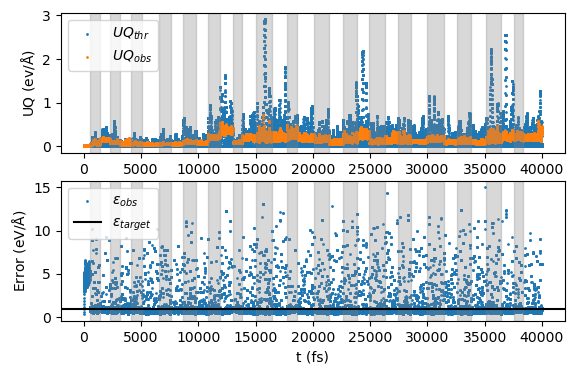

In [51]:
plot_full_controller(data, params)
plt.savefig('controller_behavior_nvt.png', dpi=500, bbox_inches='tight')
plt.show()

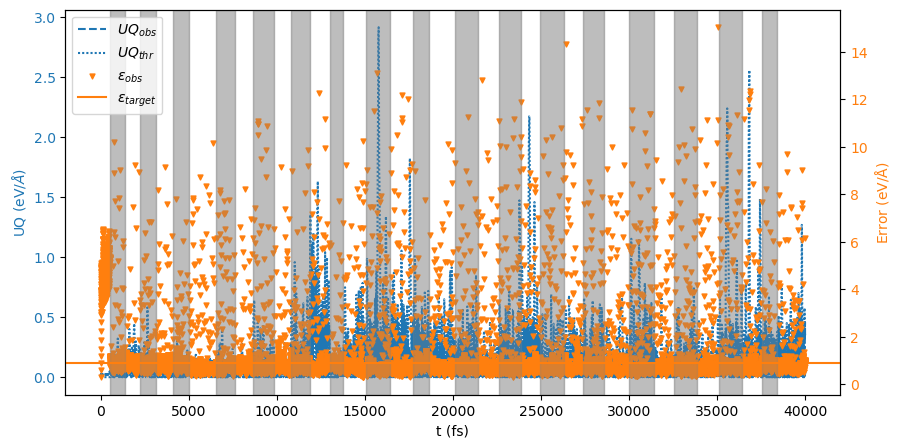

In [52]:
plot_uq_error(data, params)
plt.show()

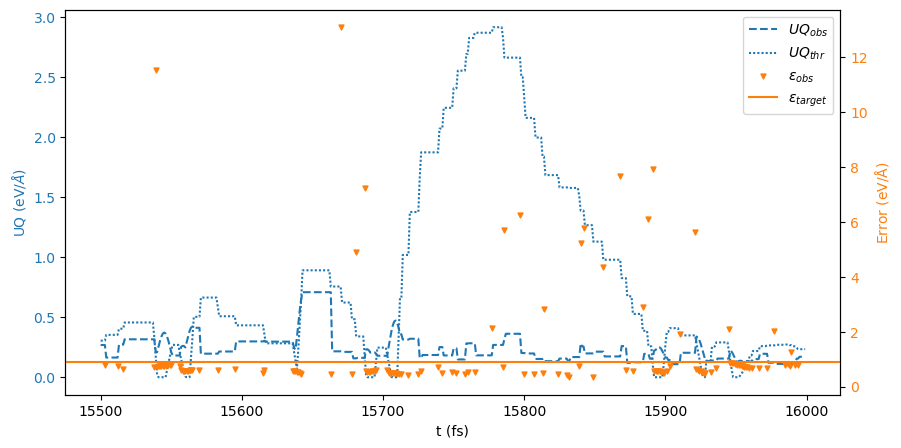

In [53]:
start, stop = 15_500, 16_000
_data = data.iloc[start:stop]
plot_uq_error(_data, params)
plt.show()

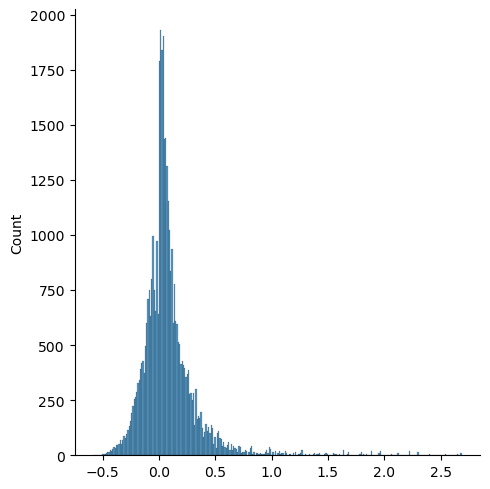

In [54]:
sns.displot(data['proxima_threshold'] - data['last_uncer'])
plt.show()

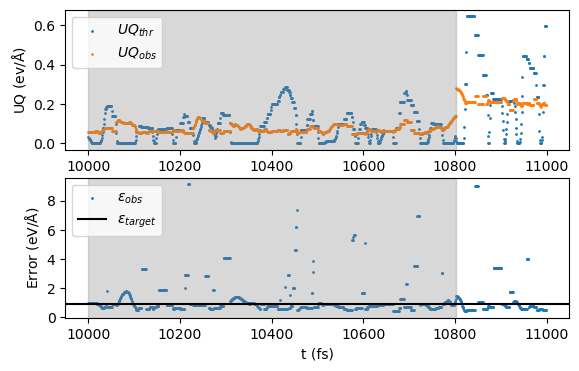

In [55]:
start, stop = 10_000, 11_000
_data = data.iloc[start:stop]
plot_full_controller(_data, params)
plt.show()

## again uq v error

In [56]:
target_steps = data[data.used_surrogate == False]

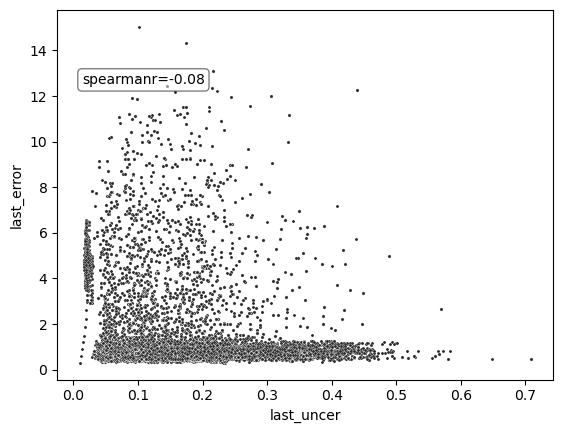

In [57]:
sns.scatterplot(x=data['last_uncer'], y=data['last_error'], s=5, color=".15")
annotate(data)
#sns.histplot(x=data['last_uncer'], y=data['last_error'], bins=50, pthresh=0.22, cmap="mako", cbar=True)
plt.show()

In [58]:
?pd.DataFrame.applymap

Signature:
pd.DataFrame.applymap(
    self,
    func: 'PythonFuncType',
    na_action: 'NaAction | None' = None,
    **kwargs,
) -> 'DataFrame'
Docstring:
Apply a function to a Dataframe elementwise.

.. deprecated:: 2.1.0

   DataFrame.applymap has been deprecated. Use DataFrame.map instead.

This method applies a function that accepts and returns a scalar
to every element of a DataFrame.

Parameters
----------
func : callable
    Python function, returns a single value from a single value.
na_action : {None, 'ignore'}, default None
    If 'ignore', propagate NaN values, without passing them to func.
**kwargs
    Additional keyword arguments to pass as keywords arguments to
    `func`.

Returns
-------
DataFrame
    Transformed DataFrame.

See Also
--------
DataFrame.apply : Apply a function along input axis of DataFrame.
DataFrame.map : Apply a function along input axis of DataFrame.
DataFrame.replace: Replace values given in `to_replace` with `value`.

Examples
--------
>>> df = pd.

In [63]:
rhos = ( 
    target_steps
    .groupby('model_version')
    .apply(
        lambda g: 
        sp.stats.spearmanr(g['last_uncer'],
                           g['last_error'])[0]
    )
)
rhos

/tmp/ipykernel_18553/3767750492.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


model_version
0    -0.090101
1    -0.102800
2     0.141648
3     0.106224
4    -0.157966
5    -0.032201
6    -0.048203
7    -0.160910
8    -0.186679
9    -0.069344
10    0.275413
11    0.222468
12    0.234274
13    0.070270
14    0.057918
15   -0.208364
16   -0.075922
17    0.173168
18    0.063861
19   -0.059620
20   -0.284584
21    0.018142
22    0.116305
23    0.123715
24    0.118983
25    0.050011
26   -0.174711
27   -0.014314
28   -0.076600
29   -0.117276
30   -0.168426
31    0.106024
32    0.009233
33    0.380170
34    0.019013
35    0.099176
dtype: float64

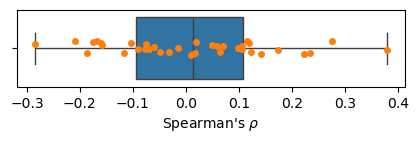

In [64]:
fig, ax = plt.subplots(figsize=(5,1))
sns.boxplot(rhos, orient='h')
sns.stripplot(rhos, color='tab:orange', orient='h')
plt.xlabel(r"Spearman's $\rho$")
plt.show()

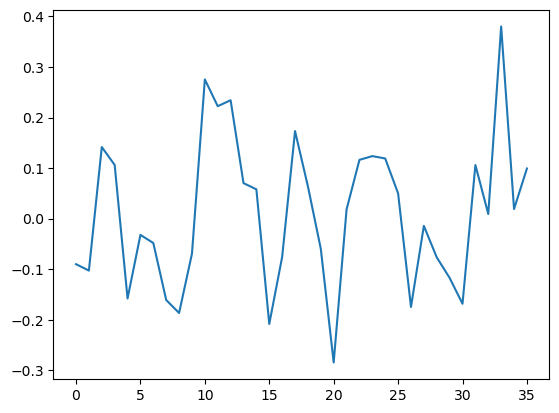

In [80]:
plt.plot(np.arange(rhos.shape[0]), rhos)
plt.show()

In [65]:
rhos.mean()

0.00994430935060114

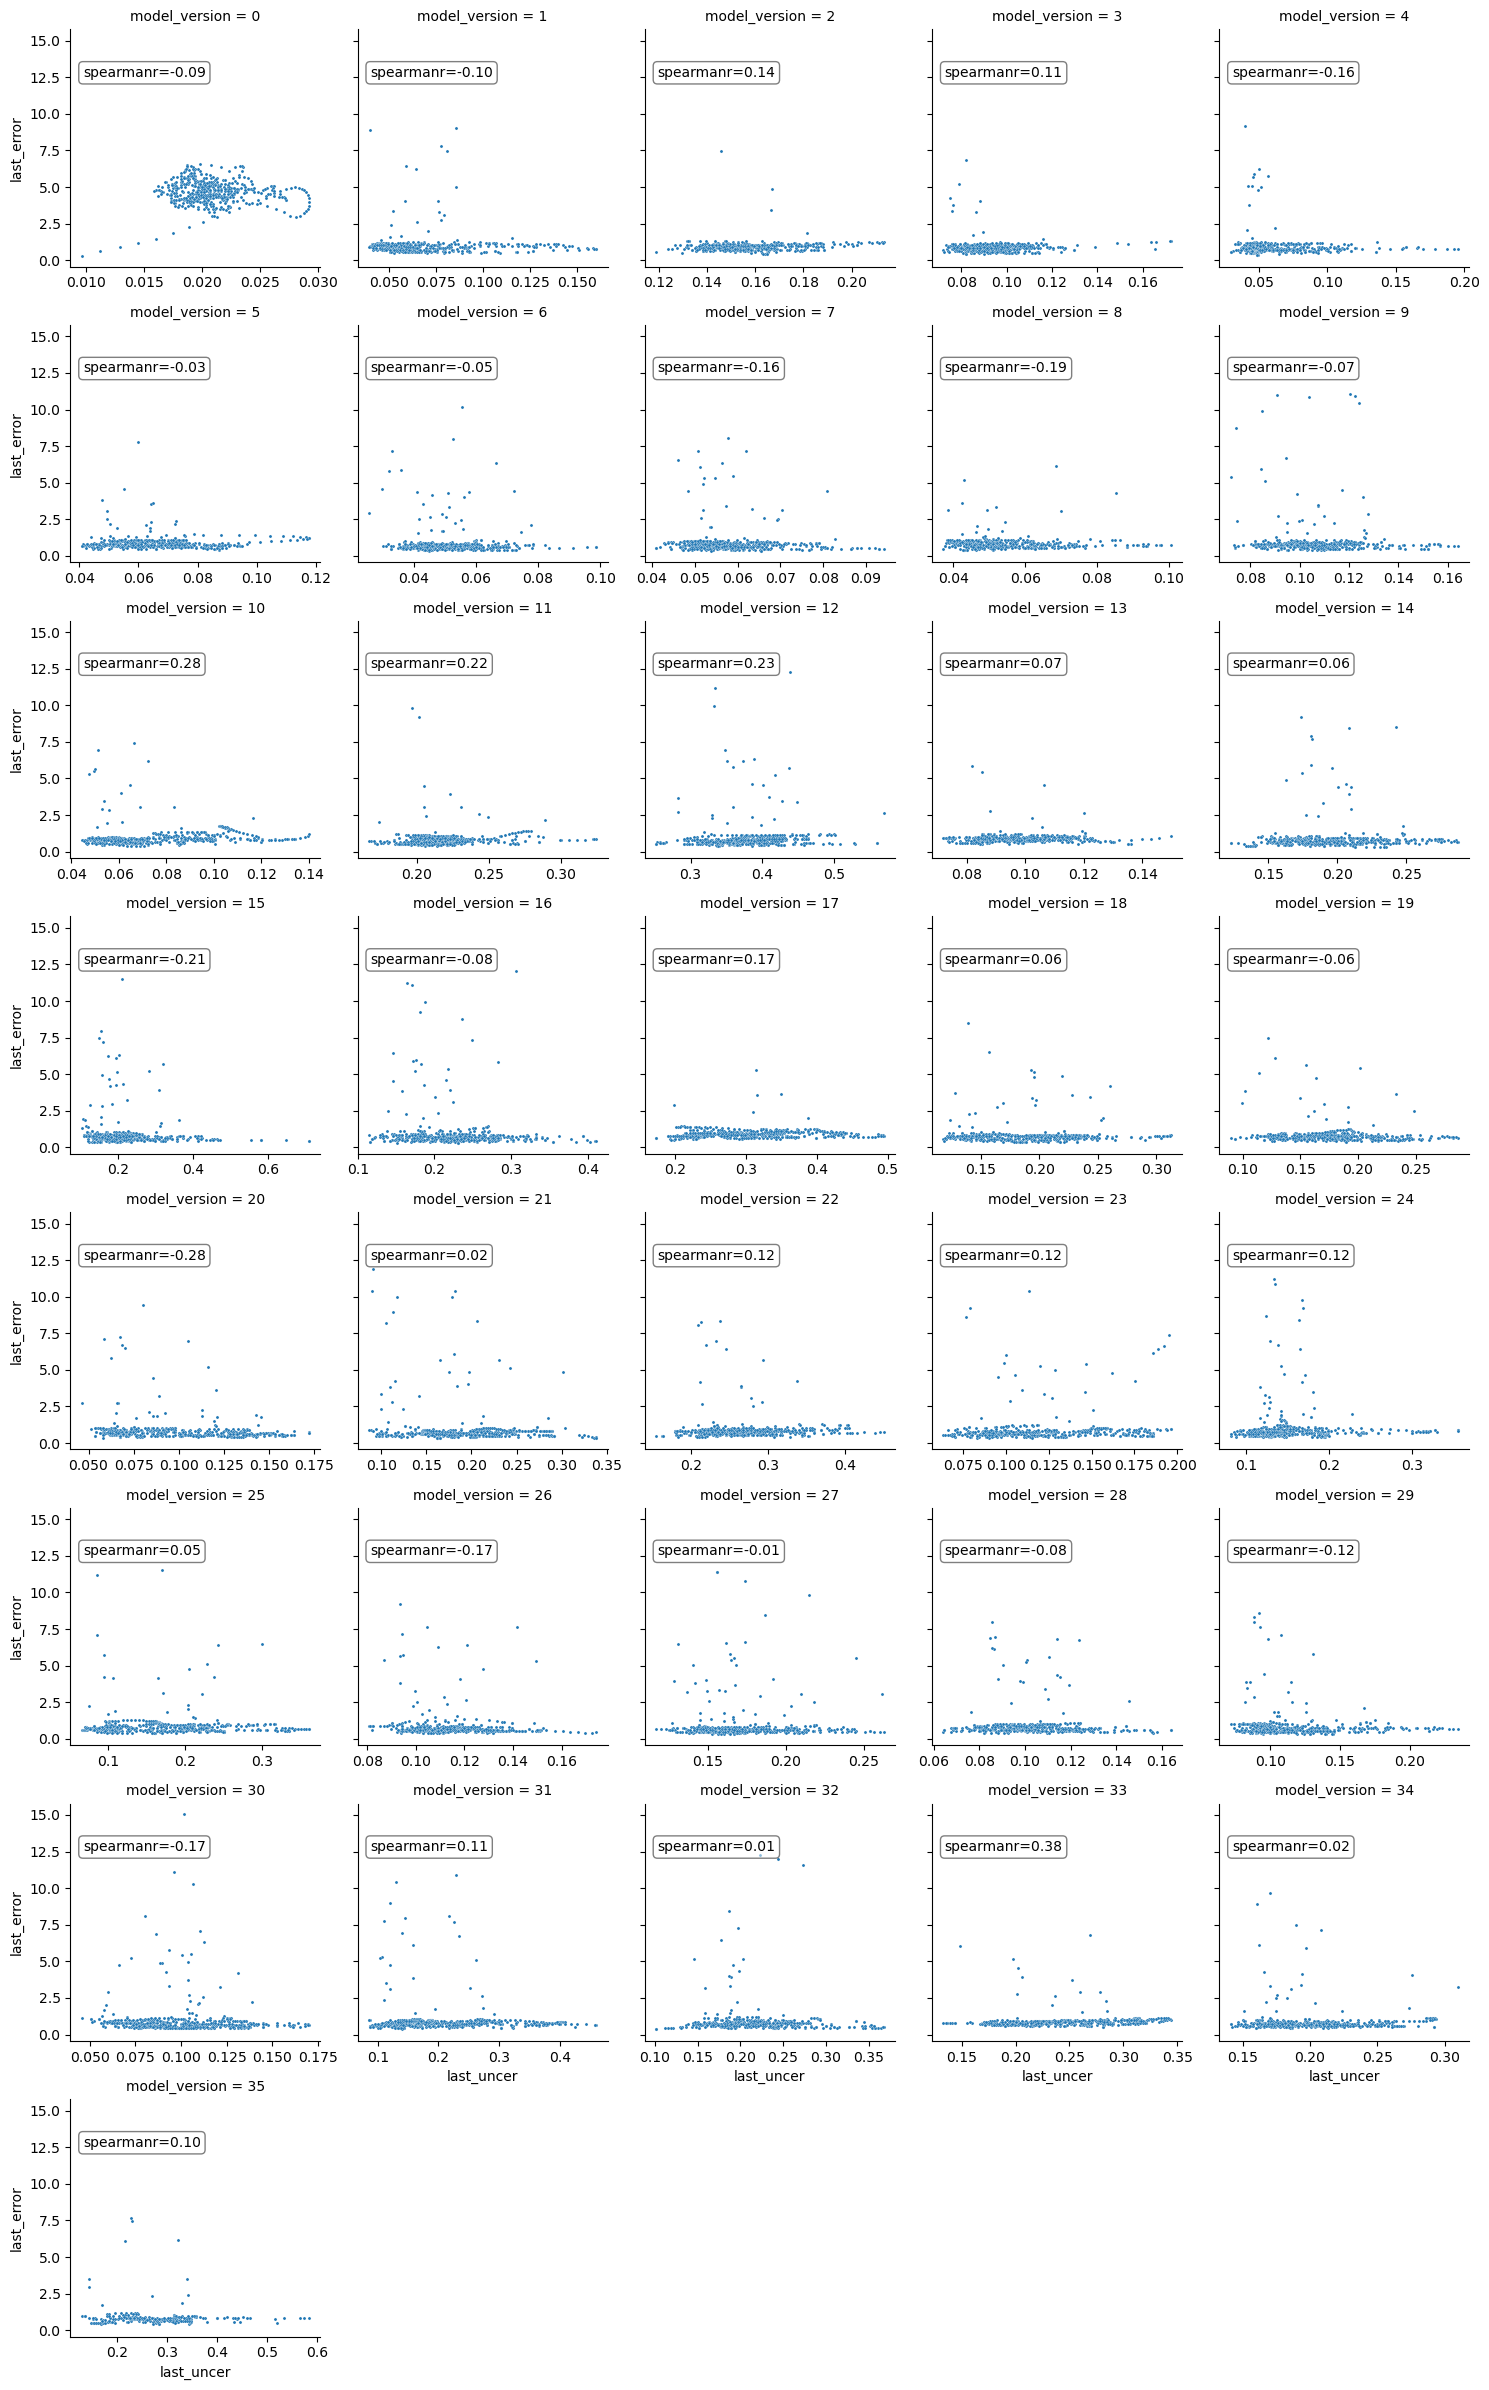

In [75]:
g = sns.FacetGrid(data=target_steps, col='model_version', col_wrap=5, sharex=False)
g.map(sns.scatterplot, 'last_uncer', 'last_error', s=5)
g.map_dataframe(annotate)
plt.show()

## False positives and such

In [67]:
uq_gt_thr = target_steps['last_uncer'] > target_steps['proxima_threshold']

In [68]:
fp = (uq_gt_thr & (target_steps['last_error'] < params['target_error'])).sum()

In [69]:
tp = (uq_gt_thr & (target_steps['last_error'] > params['target_error'])).sum()

In [70]:
uq_lt_thr = ~uq_gt_thr

In [71]:
tn = (uq_lt_thr & (target_steps['last_error'] < params['target_error'])).sum()

In [72]:
fn = (uq_lt_thr & (target_steps['last_error'] > params['target_error'])).sum()

TPR (sensitivity)

In [73]:
tp / (tp + fn)

0.8216017064184603

TNR (specificity)

In [74]:
tn / (tn + fp)

0.3565391117258337